# pk_milk demo - basic functionality

## Package import

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy import integrate
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# import the pk_milk class
from pk_milk import pk_milk


## Class argument explanation
* gens=1 :: # of generations. Gen 1 is the mother. Each subsequent gen is composed of daughters that become mothers.
* y_end=100 :: Simulation end year.
* lifespan=80 :: Lifespan of each generation (e.g., gen 1 is born in year 0 and dies in year 80). 
* brth_age=25 :: Age at which each generation gives birth. A birth schedule can be input, as well, using an embedded class function. 
* average_lact_time=[0.5]*5 :: an array (must have at least as many elements as # of gens), describing the lactation time period in years. 
* k_lac=[1e-2] * 5 :: an array (must have at least as many elements as # of gens), describing the 1st order lactation kinetic rate coefficient.  time period in years [1/years]. 
* k_elim=[np.log(2) / 5] * 5 ::  an array (must have at least as many elements as # of gens), describing the 1st order congener elemination kinetic rate coefficient [1/years]. Kinetics can also be determined by inspection of the biomonitoring data for an individual congener, as well. 
* odes_in_each_generation=2 :: the number of ode's in each gen (e.g., 2: one for body mass and one for concentration of congener in person).



## Problem statement
In this example, let's solve some problems: 
1. What is the time concentration profile of a congener in each of the 5 generations since the introduction of the chemical?
2. Which generation is at the highest risk? 
3. How does the concentration of a congener vary throughout each generation (e.g., what is the concentration of the congener for 20 year olds of each generation)?


## initialize the pk_milk class. 
1. assume the birth age is 25, so 5 generations is 125 years for the 5th gen to be born. For a lifespan of 80 years, this means that the simulation should end at: 125 + 80 or 205 years.
2. assume that the average lactation time for each generation is 10 months. 
3. assume that the 1st order lactation coefficient is 1e-1 [1/years]. 
4. assume that the 1st order kinetic elimination coefficient is log(2)/5 [1/years]. Note: k_elim can also be calculated for each congener, which will be demonstrated. 
5. assume that there are 2 ode's per generation: one for fat mass and one for chemical in fat mass. 

In [2]:
pk_milk_base = pk_milk(gens=5, y_end=205,lifespan=80, 
                       brth_age = 25, average_lact_time=[10/12]*5,
                      k_lac=[1e-2] * 5, k_elim=[np.log(2) / 5] * 5)

In [3]:
# calculate and set the delta_t. 
pk_milk_base.dt_from_timesteps_(timestep_variable=10, method='timesteps_per_month')

new timesteps/month: 10
new delta_t: 0.1


In [4]:
# calculate and set the number of simulation timesteps
pk_milk_base.n_steps_()

calculated n_steps: 2051.0


## Calculating kinetics data
###  calculate the kinetics for a congener for a single congener

k_congener_elimination: 0.180809023339 r^2:  0.887653121198


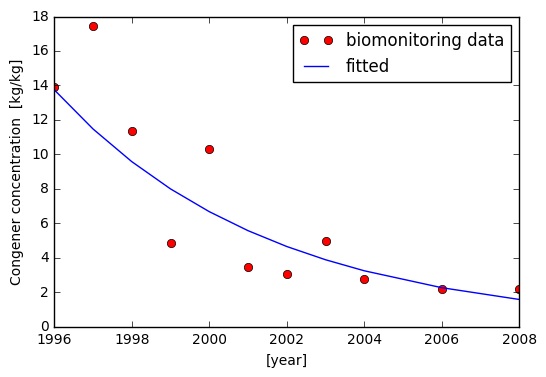

In [5]:
# grab some data
single_congener_biomonitoring_data_location = './mikes_et_al_2012.csv'
biomonitoring_data = pd.read_csv(single_congener_biomonitoring_data_location)

biomonitoring_data_years = biomonitoring_data.ix[:,0]
biomonitoring_data_congener = biomonitoring_data.ix[:,1] 

# data for biomonitoring should be as follows: 
#       years, congener_concentration
#       1999,  0.213947530915
#       2000,  0.225984883013
#       2001,  0.237058988856 

# compile to matrix, use transpose if neccessary to get the right format. 
biomonitoring_data_matrix = np.matrix([biomonitoring_data_years,biomonitoring_data_congener]).T

col_year = np.array(biomonitoring_data_matrix[:, 0]).flatten('C')
col_congener = np.array(biomonitoring_data_matrix[:, 1]).flatten('C')
year_one = col_year[0]

      
# the slope is the kinetics 
# from the class file, the lin2exp method returns: adj_year, np.polyval([slope, intercept], adj_year), slope, r_value

(x_adj_year, 
 y_congener_fitted, 
 k_congener, r_value) = pk_milk_base.biomonitoring_eval_(biomonitoring_data=biomonitoring_data_matrix)

print('k_congener_elimination:', k_congener, 'r^2: ', r_value)

# plot the kinetics: 

x_shift = list(map(lambda x: x + year_one, x_adj_year))
plt.plot(x_shift, col_congener, color='red', marker='o', linestyle='',
        label = 'biomonitoring data')
plt.plot(x_shift, np.exp(y_congener_fitted),
         color='blue', marker='', linestyle='-',label = 'fitted')
plt.legend()
plt.xlabel('[year]')
plt.ylabel('Congener concentration  [kg/kg]')
plt.show()

###  calculate the kinetics for a congener for all congeners

congoner: hcb k_elim_congener:  0.180809023339 r_value 0.887653121198
congoner: ppddt k_elim_congener:  -0.219255807619 r_value -0.731075181687
congoner: ppdde k_elim_congener:  0.0607780233246 r_value 0.625898089212
congoner: betahch k_elim_congener:  0.116200052557 r_value 0.803213402007
congoner: gammahch k_elim_congener:  0.0744602731868 r_value 0.444089964944
congoner: pcb138 k_elim_congener:  0.111532467333 r_value 0.916685949159


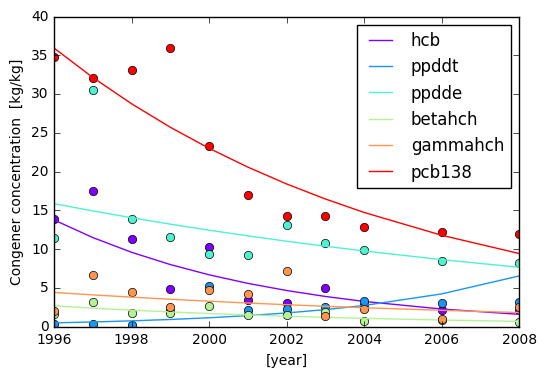

In [6]:
# grab some data
single_congener_biomonitoring_data_location = './mikes_et_al_2012.csv'
biomonitoring_data = pd.read_csv(single_congener_biomonitoring_data_location)

biomonitoring_data_years = biomonitoring_data.ix[:,0]

# find the total number of congeners. 
list_of_congeners = list(biomonitoring_data)[1:] # first value is the 'year' header

# define a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(list_of_congeners)))

for congener,c in zip(list_of_congeners, colors):
    # create import matrix with single congener
    biomonitoring_data_congener = biomonitoring_data[congener] 
    biomonitoring_data_matrix = np.matrix([biomonitoring_data_years,biomonitoring_data_congener]).T

    col_year = np.array(biomonitoring_data_matrix[:, 0]).flatten('C')
    col_congener = np.array(biomonitoring_data_matrix[:, 1]).flatten('C')
    year_one = col_year[0]
    
    (x_adj_year, 
     y_congener_fitted, 
     k_congener, r_value) = pk_milk_base.biomonitoring_eval_(biomonitoring_data=biomonitoring_data_matrix)
    
    print('congoner:', congener, 'k_elim_congener: ', k_congener,'r_value', r_value)

    x_shift = list(map(lambda x: x + year_one, x_adj_year))
    plt.plot(x_shift, col_congener, color=c, marker='o', linestyle='')
    plt.plot(x_shift, np.exp(y_congener_fitted),
             color=c, marker='', linestyle='-', label = congener)
plt.legend()
plt.xlabel('[year]')
plt.ylabel('Congener concentration  [kg/kg]')
plt.show()

## Determining lipid mass from bodyweight and lipid fraction.

In [7]:
# import matrix 'bodyweight_and_lipid_fraction_data'
# example
bodyweight_and_lipid_fraction_location = './monthly_bodyweight_and_lipid_fraction.csv'
bodyweight_and_lipid_fraction_dataframe = pd.read_csv(bodyweight_and_lipid_fraction_location)
bodyweight_and_lipid_fraction_matrix = bodyweight_and_lipid_fraction_dataframe.as_matrix()

lipid_mass_array = pk_milk_base.lipid_mass_from_bw_and_lipid_fraction(bodyweight_and_lipid_fraction_matrix)

## Create, or provide your own, intake intensity curve. 

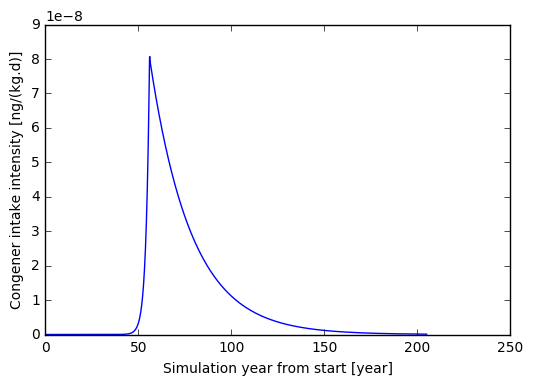

In [8]:
# the curve is then a callable function that can be imported into the mass balance
pk_milk_base.intake_intensity_curve_(method='asymettric_exp_up_and_down', year_peak = 56, peak_intensity=80e-9)

# this function is stored in the pk_milk_base class (or whatever you name it) and can be recalled/plotted 
x_simulation = np.linspace(pk_milk_base.y_start, pk_milk_base.y_end, pk_milk_base.n_steps)
plt.plot(x_simulation, pk_milk_base.intake_intensity_curve(x_simulation))
plt.xlabel('Simulation year from start [year]')
plt.ylabel('Congener intake intensity [ng/(kg.d)]')
plt.show()

## Generate the age timeline data. 
Because multi-generational math requires keeping track of when each generation was born (or died), employ the age_timeline_ function. 

After this data has been generated, employ the age_splines_ function to create age spline array that holds the continuous functions describing the mass of fat in the body. The age_timeline_ function needs to be performed first, because it sets into the class several timeline descriptors based on the provided birth schedule and lifespan. 


default interval age at which mother gives birth:  25 years
calculated birth time-table based on birth age: [   0.   25.   50.   75.  100.  125.] years
generational birth schedule: [25.0, 50.0, 75.0, 100.0, 125.0, 150.0] years
generational death schedule: [80.0, 105.0, 130.0, 155.0, 180.0, 205.0] years


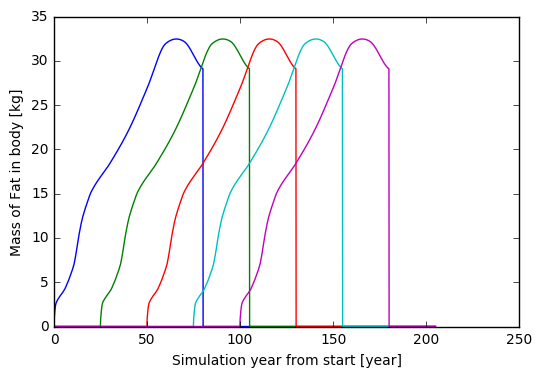

In [9]:
pk_milk_base.age_timeline_()
pk_milk_base.age_splines_(lipid_mass_array=lipid_mass_array) # lipid_mass_array defined above.

# if you want to plot the age splines output, you can. However, make sure not to plot the derivatives!
for gen in range(0, pk_milk_base.gens):
    plt.plot(x_simulation, pk_milk_base.age_spline[gen](x_simulation))
plt.xlabel('Simulation year from start [year]')
plt.ylabel('Mass of Fat in body [kg]')
plt.show()

## run the generation_mass_balance
now that everything is set, feel free to run the generation_mass_balance function. 

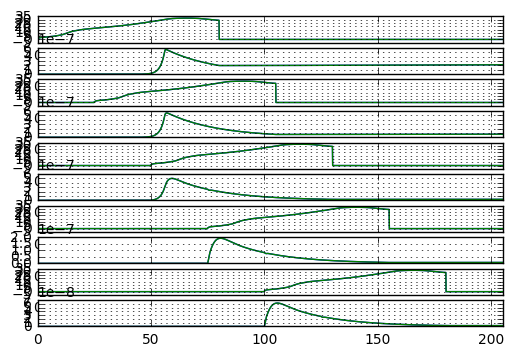

In [10]:
# run the generation mass balance. Turn on quickplot to just plot the data. 
pk_milk_base.generation_mass_balance(quickplot = True)



# Answering Q's with the model
1. What is the time concentration profile of a congener in each of the 5 generations since the introduction of the chemical?
2. Which generation is at the highest risk? 
3. How does the concentration of a congener vary throughout each generation (e.g., what is the concentration of the congener for 20 year olds of each generation)?


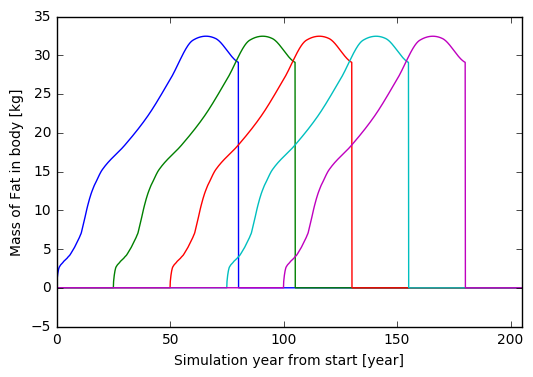

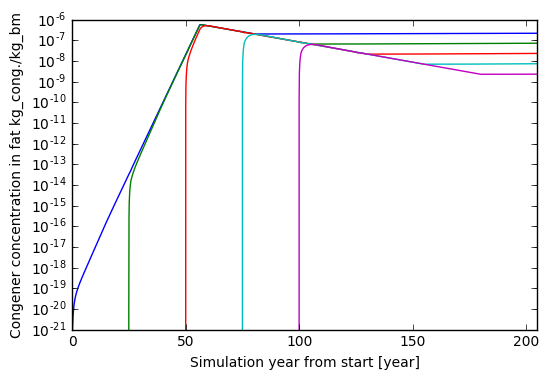

In [11]:
# data can also be extracted by calling the dydt_solution function for each mass balance: 

# # plot only the mass compartments for each generation
for gen in range(0, pk_milk_base.gens*pk_milk_base.odes_in_each_generation)[::2]:
    plt.plot(x_simulation, pk_milk_base.dydt_solution[gen][:])
    plt.xlim(x_simulation[0],x_simulation[-1])
plt.xlabel('Simulation year from start [year]')
plt.ylabel('Mass of Fat in body [kg]')
plt.show()

# plot only the chemical mass compartments for each generation
for gen in range(0, pk_milk_base.gens*pk_milk_base.odes_in_each_generation)[1::2]:
    plt.plot(x_simulation, pk_milk_base.dydt_solution[gen][:])
    plt.xlim(x_simulation[0],x_simulation[-1])
    plt.yscale('log')
plt.xlabel('Simulation year from start [year]')
plt.ylabel('Congener concentration in fat kg_cong./kg_bm')
plt.show()